In [29]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def step_function(r, x_t, f_x, g,  d_t, x0, L): #Algorithm 3
    if type(x0) == int:
        x0 = x_t 
        #print("x0:", x0)
    epsilon = 10e-3
    k1 = 0.9
    k2 = 2
    nL = k1 * L
    den=d_t.T @ d_t # ||d||^2
    if den==0: # since it goes to the denominator I check that it is not 0
      den=0.0000001 #think about substituting this with a stop of the algorithm
    clip = g ** 2 / ((2 * (objective(x0, r) - f_x) * den)+0.0000001) # this value ha to be comprised between nL and L
    
    M = np.clip(clip ,nL, L) ## the value clip is bounded by upper bound nL and lower bound L 
    
        
        
    
    bound = g / (M * den) 
    gamma = min(bound, 1)
    #whiel the function is bigger than quadratic approximation do:
    while objective(x_t + (gamma * d_t), r) > (f_x - (gamma * g) + ( (gamma ** 2) * M) * (den)) : 
        M = k2 * M
        bound = g / ((M * den)+0.0000001) 
        
        gamma = min(bound, 1)
    return gamma,  M

The computation of the cost function can be seen as matrix multiplication between:

*    $R$ with size $(m, n)$, where $m$ is the number of periods and $n$ is the number of assets, so that the row $i$ represents the value of the return of each assets in the period $i$
*   $x$ that is the column vector with shape $(n, 1)$ that gives us the percentage to invest for each asset.

In this way the matrix multiplication between each row of $R$ and $x$ will correspond to exponential of the each element of the summatory $\sum_{i=1}^{T} ln(r_{i}x)$, where $T$ is the number of period. So what is left is to apply the logaritmic function to every of those terms.



In [3]:
def objective(x, r):
  x=x.reshape(-1,1) #reshape the vector to perform the next operation
  a=np.dot(r, x ) #dot product
  a=np.where(a!=0, a, a+0.00000001) #eleminating eventual zero elements
  #a will be a vector of m elements, one for each period
  return np.sum(-np.log(a))

The computation of the gradient follows the same logic as before, we will get a colum vector of 250 elements, and then we will perform an element wise multiplication between this vector and the matrix $R$. After this we will sum with respect to the colum in order to get the gradient for each element of $x$.

In [4]:
def gradient(x, r):
  x=x.reshape(-1,1)
  a=np.dot(r, x )
  a=np.where(a!=0, a, a+0.00000001) #up to here same as befor
  return np.sum(-(1/a)*r, axis=0) # multiplying for R and summing with respect to the column

In [5]:
def arimjo_ls(xt, fx, gamma_max, gt, dt, r):
    gamma = gamma_max
    p = 0.1*(-gt) # quantity that goes in the armijo line search
    f= objective(xt + gamma * dt, r)
    while (f > (fx + gamma * p)): # while the function is biggr than the linear approximation
      gamma=0.7*gamma #reduce the step size
      f = objective(xt + gamma * dt, r) 
    return gamma
    

In [6]:
def LMO(simplex, gradient_xt): 
    sti = np.argmin(gradient_xt) 
    st = simplex[sti] # simplex[sti] only thing left to be defined is simplex
    return st, sti

In [32]:
def frank_wolfe(objective,  gradient, return_matrix,  max_iter):
    # n_periods = return_matrix.shape[0]
    n_assets = return_matrix.shape[1]
    
    eps = 1e-6
    # Our solution is a vector x, |x| = n_assets - 
    # investment distribution
    # We pick initial approximation for x - any
    # simplex vertex
    vertex_to_start = 1
    assert vertex_to_start < n_assets, print('Pick another initial approximation')
    x = np.zeros(n_assets)
    x[vertex_to_start] = 1  # initial approximation - all money to one asset

    objective_values = [objective(x, return_matrix)]  # objective function
    gap_list=[]
    for k in range(1, max_iter + 1):
        
        # Compute gradient of objective function
        grad_vector = gradient(x, return_matrix)
        #assert(grad_vector.shape[0] == len(x))

        # FW for simplex problem --> minimum of linear
        # function will be reached on the vertex of the simplex
        # Here we search for index with minimum gradient
        # component
        min_index = np.argmin(grad_vector)
        #assert grad_vector[min_index] <= 0, print(f'Minimum of gradient vector is positive')
        
        # x_k^ = e_ik from lectures - direction where to go
        xk_hat = np.zeros(n_assets)
        assert(len(xk_hat) == len(grad_vector))
        xk_hat[min_index] = 1
        d = (xk_hat - x)
        gap=-grad_vector @ d
        gap_list.append(gap)
        if gap <= eps:
            print(f'Satisfied exiting condition')
            break
        else:
            learning_rate = 2 / (k + 1)
            x = x + learning_rate * d
            obj = objective(x, return_matrix)
            
            objective_values.append(obj)  # objective function

     # that sum of distribution is 100%
    
    return x, objective_values, gap_list

In [52]:
def variant2(objective,  gradient, r,  max_iter = 1000):
  eps = 1e-6
  active_set=np.eye(r.shape[1])
      
  xt  = active_set[0, :]
  x0=0 #initialize this variable to keep track of the previus value of x w.r.t. to the curret iteration
  #it is needed in the step_function
  gap_list=[]
  
  o=[] #store the objective function values during the iteration
  for i in range(max_iter):
    if i==0:
        
        L=1 #initialize the L costant, to be sostituted with the right euristic
    
    g  = gradient(xt, r)
    fxt  = objective(xt,r )
    o.append(fxt)
    st, sti = LMO(active_set, g)#linear minimizer oracle
    d =  st - xt 
    gap=- g @ d #computing the gap
    gap_list.append(gap)
    if gap<= eps: #checking the stopping condition
      print('early exit')
      return [xt,o, gap_list]
    gamma, L = step_function(r, xt, fxt, gap,  d, x0, L)
    x0=xt #keeping track of the past value of x for the next iteration
    
    xt += gamma*d #updating x
  return [xt,  o, gap_list]

In [51]:
def FW_PW_correct(objective,  gradient, r,  max_iter = 1000):
    eps = 1e-6
    active_set=np.eye(r.shape[1]) # the active set has as vertexes the characteristic vectors
    gap_list=[]
    
    
    xt  = active_set[0, :] #itiliaze x with the fisrt vertex
    #for the part of the code concerning the weights see the paper for a more detailed explenations
    ind=[0] #list of indexes correspondig to the vertexes that are into set1 (see below)
    weights = np.zeros(r.shape[1]) #we have a weight for each vertex of the active set
    #we also have another set (set1 corresponding to S in the paper) where there 
    #are all the vertexes that can be chosen to compute the away direction
     
    weights[ind] = 1 #we set the weights corresponding to the vertexes that are in set1 equal to one, the rest is equal to zero
    
    o=[] 
    for i in range(max_iter):
        
        set1=active_set[ind,:] #create the set1 where there are all the vertexes with the corresponding weights different from 0
        g  = gradient(xt, r)
        fxt  = objective(xt,r )
        o.append(fxt)
        st, sti = LMO(active_set, g) #linear minimizer oracle
        vti = np.argmax(g[ind]) #away vertex
        vt = set1[vti]

        vti=ind[vti] #trick, since vti will correspond to the index in set1, that is smaller than active set 
        #I retrive the corresponding index in the active set
        
        dt = st - vt #pairwise direction
        gfw =  - g @ dt #gap
        gap_list.append(gfw)
        if gfw <= eps: #stopping condition
          print('early exit')
          return [xt,o, gap_list]
         
        gamma_max = weights[vti] #gamma max equal to the weight corresponding to the away vertex
        
        gamma = arimjo_ls(xt, fxt, gamma_max, gfw, dt, r)
        weights[vti] -= gamma #updating the weights according to the paper
        weights[sti] += gamma
        ind=(np.array(list(range(weights.shape[0])))[(weights>0)]).tolist() #updating the list of indexes correspondig to the non zero weights
        if (abs(xt[vti]) <= 0.0001): #removing weights that are too little
            active_set = np.delete(active_set, vti, 0)
            weights = np.delete(weights, vti)
        
        
        
        xt += gamma*dt
    return [xt,  o, gap_list]

In [40]:
def plot_objective_function(values):
    fig, ax = plt.subplots()

    for a, s in values.items():
        ax.plot(s, marker = 'o', markerfacecolor = 'white', label=a)
        leg = ax.legend()
    plt.xlabel('Number of iteration')
    plt.ylabel('Objective function')
    plt.title('Objective function')
    plt.grid()

In [46]:
def plot_gap(values):
    fig, ax = plt.subplots()

    for a, s in values.items():
        ax.plot(s, marker = 'o', markerfacecolor = 'white', label=a)
        leg = ax.legend()
    plt.xlabel('Number of iteration')
    plt.ylabel('Relative Error')
    plt.title('Relative Error')
    plt.grid()

In [11]:
def plot_return_matrix(return_matrix, x_lim, assets):
    fig, ax = plt.subplots()

    for asset in assets:
        ax.plot(return_matrix[:x_lim, asset], marker = 'o', markerfacecolor = 'white')

    plt.ylim([0, 1.5])
    plt.xlabel('Period 1 .. T')
    plt.title(f'First {x_lim} samples for {len(assets)} assets')
    plt.ylabel('Return')
    plt.legend([f'Asset {n}' for n in assets])
    plt.grid()

In [58]:
def run_experiment(n_assets, n_periods, max_iterations, fun):
    mean = 0  # like in paper
    var = 0.1  # like in paper
    np.random.seed(43)
    i={}
    o={}
    g={}
    t={}
    # Create return matrix as in the paper
    # (N periods) x (N assets) matrix
    return_matrix = np.ones((n_periods, n_assets)) + np.random.normal(loc = mean, scale = var, size = (n_periods, n_assets))
    assert(return_matrix.shape == (n_periods, n_assets))
    assert(len(return_matrix[:, 0]) == n_periods)
    assert(len(return_matrix[0, :]) == n_assets)

    plot_return_matrix(return_matrix, x_lim = 100, assets = [0, 1, 2])
    for f in fun:
      start=time.time()
      investment_distribution, objective_func, gap = f(objective,  gradient, return_matrix,  max_iter = max_iterations)
      stop=time.time()
      
      i[f'{f.__name__}']=investment_distribution
      o[f'{f.__name__}']=objective_func
      g[f'{f.__name__}']=gap
      t[f'{f.__name__}']=stop-start

    plot_objective_function(o)
    plot_gap(g)
    print('Time to execution :', t)
    return investment_distribution, objective_func, g

Time to execution : {'frank_wolfe': 0.014597415924072266, 'variant2': 0.013798713684082031, 'FW_PW_correct': 0.05301499366760254}
True


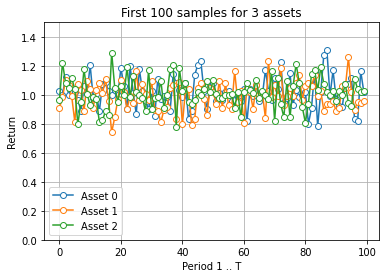

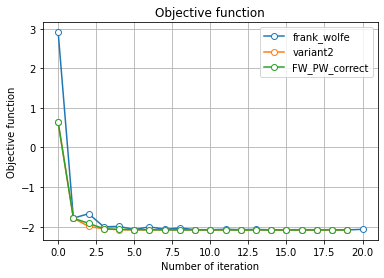

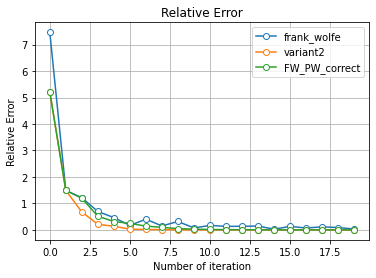

In [59]:
np.random.seed(43)
investments, objective_func, g = run_experiment(20, 250, 20, [frank_wolfe, variant2, FW_PW_correct])
print(investments.sum()==True)